# Cluster Analysis of BostonBlueBikes

In [1]:
import numpy as np
import pandas as pd
import folium
from math import sin, cos, pi
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt



## Load processed dataframe

In [2]:
df_boston = pd.read_csv('./data/prepared/rides_data_prepared.csv', dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')
df_boston['end_time'] = pd.to_datetime(df_boston['end_time'], format='%Y-%m-%d %X')
df_boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122554 entries, 0 to 1122553
Data columns (total 14 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   start_time               1122554 non-null  datetime64[ns]
 1   end_time                 1122554 non-null  datetime64[ns]
 2   start_station_id         1122554 non-null  int64         
 3   end_station_id           1122554 non-null  string        
 4   start_station_name       1122554 non-null  string        
 5   end_station_name         1122554 non-null  string        
 6   bike_id                  1122554 non-null  int64         
 7   user_type                1122554 non-null  string        
 8   trip_length              1122554 non-null  float64       
 9   start_station_latitude   1122554 non-null  float64       
 10  start_station_longitude  1122554 non-null  float64       
 11  end_station_latitude     1122554 non-null  float64       
 12  

In [29]:
df_boston.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,trip_length,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,date_time
0,2015-01-01 00:21:44,2015-01-01 00:30:47,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,277,Subscriber,543.0,42.387995,-71.119084,42.373379,-71.111075,2015-01-01 00:00:00
1,2015-01-01 00:27:03,2015-01-01 00:34:21,80,95,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,648,Subscriber,438.0,42.361962,-71.092053,42.372969,-71.094445,2015-01-01 00:00:00
2,2015-01-01 00:31:31,2015-01-01 00:35:46,91,68,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,555,Subscriber,255.0,42.366277,-71.091690,42.365070,-71.103100,2015-01-01 01:00:00
3,2015-01-01 00:53:46,2015-01-01 01:00:58,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber,432.0,42.387995,-71.119084,42.373379,-71.111075,2015-01-01 01:00:00
4,2015-01-01 01:07:06,2015-01-01 01:19:21,105,88,Lower Cambridgeport at Magazine St/Riverside Rd,Inman Square at Vellucci Plaza / Hampshire St,177,Customer,735.0,42.356954,-71.113687,42.374035,-71.101427,2015-01-01 01:00:00


## Clustering of trip types

### Data Prep and Scaling

##### We prepare a dataframe that simply includes time of rental as well as the trip length. We consider not only daytime but also the weekday the bike was rented. 

In [12]:
trip_types = df_boston[['start_time', 'start_station_id', 'trip_length', 'user_type']].copy()
trip_types.loc[:,'hour'] = trip_types['start_time'].apply( lambda x: x.hour + (x.minute/60))
trip_types.loc[:, 'weekday'] = trip_types['start_time'].apply(lambda x: x.day_of_week)
#trip_types.loc[:, 'season'] = trip_types['start_time'].apply(lambda x: x.month%12//3 +1)

In [13]:
trip_types['trip_length'] = trip_types['trip_length'].apply(lambda x: x/3600)
trip_types = trip_types.rename(columns = {'trip_length' : 'duration_in_hours'})

In [14]:
trip_types.head()

,start_time,start_station_id,duration_in_hours,user_type,hour,weekday
0,2015-01-01 00:21:44,115,0.150833,Subscriber,0.350000,3
1,2015-01-01 00:27:03,80,0.121667,Subscriber,0.450000,3
2,2015-01-01 00:31:31,91,0.070833,Subscriber,0.516667,3
3,2015-01-01 00:53:46,115,0.120000,Subscriber,0.883333,3
4,2015-01-01 01:07:06,105,0.204167,Customer,1.116667,3


In [15]:
trip_types = trip_types.loc[trip_types['duration_in_hours'] < 1.5]

##### Include circular feature of time variables -> otherwise problem with standardization (why?)

In [24]:
def circular( name, feature, dataframe, n):
    dataframe[name + '_sin'] = feature.apply(lambda x: sin(2*pi*(x/n)))
    dataframe[name + '_cos'] = feature.apply(lambda x: cos(2*pi*(x/n)))

circular('hour', trip_types.hour, trip_types, 24)
circular('weekday', trip_types.weekday, trip_types, 7)

trip_types_subs = trip_types.loc[trip_types['user_type'] == 'Subscriber']
trip_types_cus = trip_types.loc[trip_types['user_type'] == 'Customer']

X = trip_types.drop(['hour', 'weekday', 'start_time', 'start_station_id',  'user_type'], axis = 1)
X_s = trip_types_subs.drop(['hour', 'weekday', 'start_time', 'start_station_id', 'user_type'], axis = 1)
X_c = trip_types_cus.drop(['hour', 'weekday', 'start_time', 'start_station_id', 'user_type'], axis = 1)


In [25]:
X.head()

,duration_in_hours,hour_sin,hour_cos,weekday_sin,weekday_cos
0,0.150833,0.091502,0.995805,0.433884,-0.900969
1,0.121667,0.117537,0.993068,0.433884,-0.900969
2,0.070833,0.134851,0.990866,0.433884,-0.900969
3,0.120000,0.229200,0.973379,0.433884,-0.900969
4,0.204167,0.288196,0.957571,0.433884,-0.900969


##### Scaling variables to ensure same weights

In [26]:

def scaling(x):
    scaler= StandardScaler()
    scaler.fit(x)
    x_scaled = scaler.transform(x)
    x_scaled_df = pd.DataFrame(x_scaled, columns = x.columns, index = x.index)
    return x_scaled, x_scaled_df

X_scaled, X_scaled_df = scaling(X)
X_scaled_s, X_scaled_df_s = scaling(X_s)
X_scaled_c, X_scaled_df_c = scaling(X_c)


In [27]:
trip_types_scaled = X_scaled_df
trip_types_scaled_s = X_scaled_df_s
trip_types_scaled_c = X_scaled_df_c

In [11]:
trip_types_scaled.head()

,duration_in_hours,hour_sin,hour_cos,weekday_sin,weekday_cos
0,-0.441465,0.526427,2.321409,0.516016,-1.191778
1,-0.604849,0.562990,2.316545,0.516016,-1.191778
2,-0.889603,0.587304,2.312630,0.516016,-1.191778
3,-0.614185,0.719805,2.281546,0.516016,-1.191778
4,-0.142707,0.802656,2.253447,0.516016,-1.191778


### Choose number of clusters (K): elbow method

In [32]:
k_max = 15 

def k_optimal(X_scaled):
    clusters = []
    losses = []
    for k in range(k_max):
        model= MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++") 
        model.fit(X_scaled)
        clusters.append(k+1)
        losses.append(model.inertia_)
    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.show()


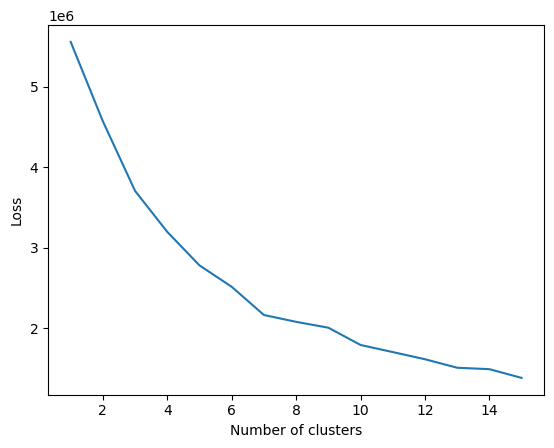

In [33]:
k_optimal(X_scaled)

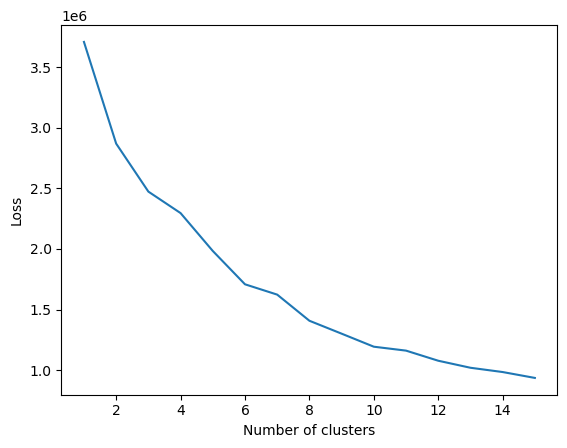

In [34]:
k_optimal(X_scaled_s)

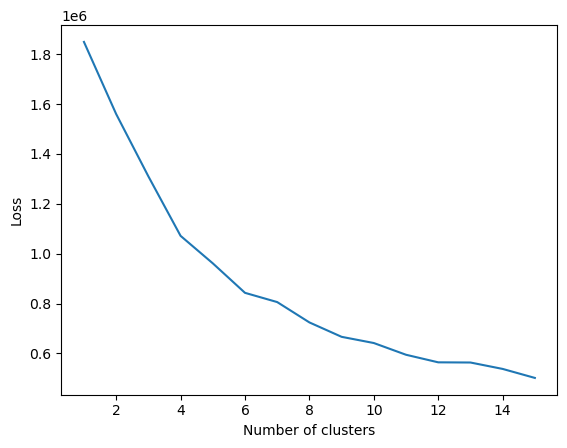

In [35]:
k_optimal(X_scaled_c)

From this graph we inferr that a good amount of clusters lies within the range of 6-10, which is why we choose 7 as the 'optimal' amount of clusters. 

### Clustering

In [52]:
# refit algorithm full data

means = MiniBatchKMeans(n_clusters=7, random_state=42,init="k-means++")
means.fit(X_scaled)

numbers = ['after work \n (early week)', 'work and lunch \n (late week)', 'party\n (weekend)', 'trips\n (weekend)', 'work and lunch\n (early week)', 'long distance\n trips', 'after work\n (late week)']

#add cluster lables to the dataset
trip_types_scaled["cluster"] = means.predict(X_scaled)
trip_types_scaled["cluster"] = trip_types_scaled["cluster"].apply(lambda x: numbers[x])

trip_types_scaled['hour'] = trip_types.hour
trip_types_scaled['weekday'] = trip_types.weekday
trip_types_scaled['duration_in_hours'] = trip_types.duration_in_hours
trip_types_scaled["start_station_id"]=trip_types.start_station_id


In [45]:
# refit algorithm subsriber data

means_s = MiniBatchKMeans(n_clusters=7, random_state=42,init="k-means++")
means_s.fit(X_scaled_s)

numbers_s = ['one', 'two', 'three', 'four', 'five', 'six', 'seven']

#add cluster lables to the dataset
trip_types_scaled_s["cluster"] = means_s.predict(X_scaled_s)
trip_types_scaled_s["cluster"] = trip_types_scaled_s["cluster"].apply(lambda x: numbers_s[x])

In [46]:
# refit algorithm customer data

means_c = MiniBatchKMeans(n_clusters=7, random_state=42,init="k-means++")
means_c.fit(X_scaled_c)

numbers_c = ['one', 'two', 'three', 'four', 'five', 'six', 'seven']

#add cluster lables to the dataset
trip_types_scaled_c["cluster"] = means_c.predict(X_scaled_c)
trip_types_scaled_c["cluster"] = trip_types_scaled_c["cluster"].apply(lambda x: numbers_c[x])

In [50]:
trip_types_scaled.head()

,duration_in_hours,hour_sin,hour_cos,weekday_sin,weekday_cos,cluster,hour,weekday,start_station_id
0,0.150833,0.526427,2.321409,0.516016,-1.191778,after work\n (late week),0.350000,3,115
1,0.121667,0.562990,2.316545,0.516016,-1.191778,after work\n (late week),0.450000,3,80
2,0.070833,0.587304,2.312630,0.516016,-1.191778,after work\n (late week),0.516667,3,91
3,0.120000,0.719805,2.281546,0.516016,-1.191778,after work\n (late week),0.883333,3,115
4,0.204167,0.802656,2.253447,0.516016,-1.191778,after work\n (late week),1.116667,3,105


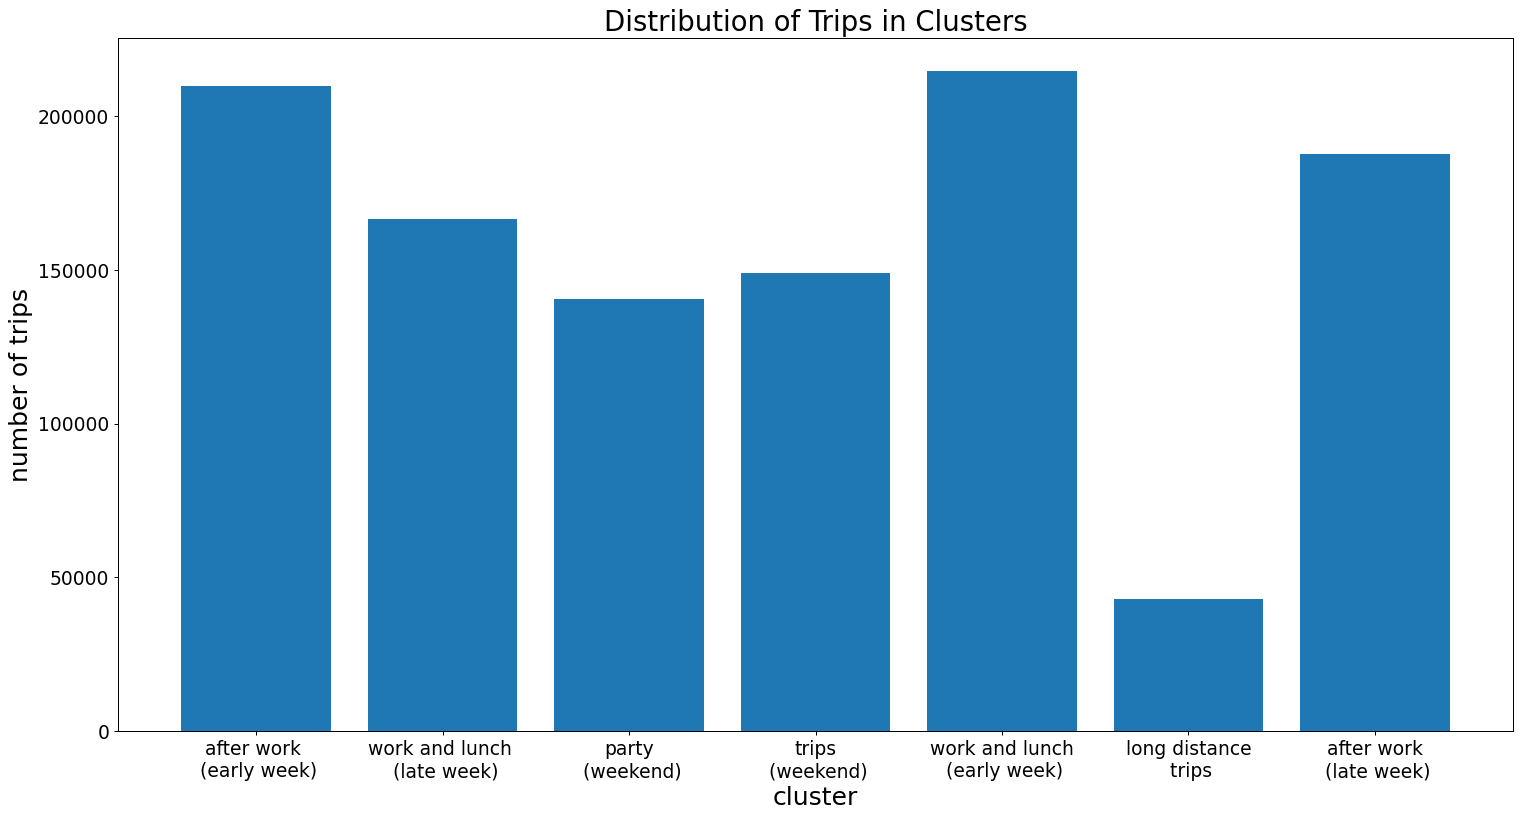

In [54]:
#full data
count = [len(trip_types_scaled[trip_types_scaled.cluster==numbers[i]]) for i in range(len(numbers))]

fig,ax = plt.subplots(figsize=(20,10), dpi=90) 
axis_font = {'size':'20'}
label_font = {'labelsize':'15'}
dic={'fontsize': '22'}

ax.set_title("Distribution of Trips in Clusters", dic)
ax.set_ylabel("number of trips", **axis_font)
ax.set_xlabel("cluster", **axis_font)
ax.tick_params(axis='both', **label_font)
    
plt.bar(numbers,count)
plt.show()

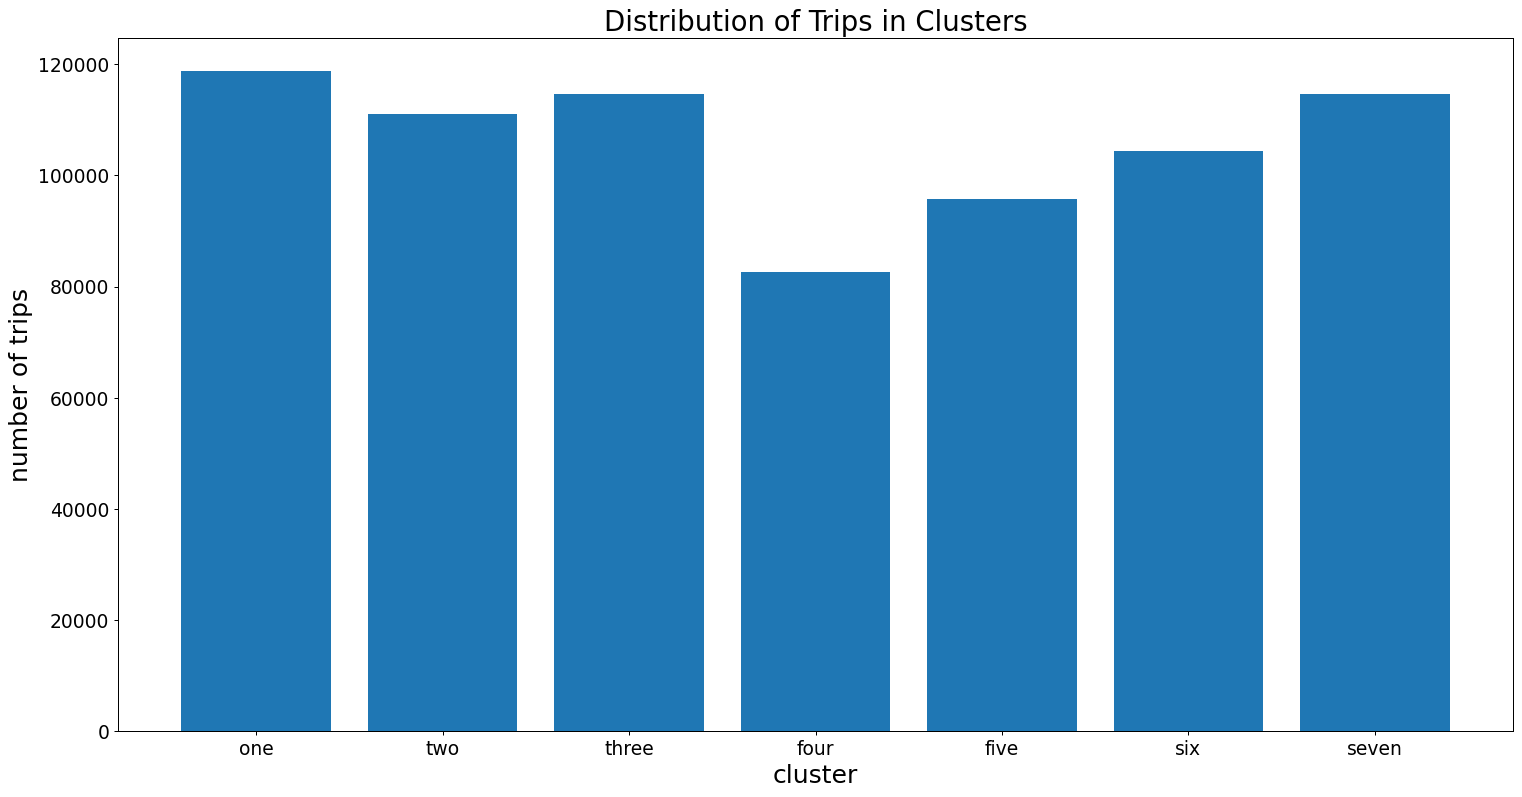

In [55]:
#subscriber data
count_s = [len(trip_types_scaled_s[trip_types_scaled_s.cluster==numbers_s[i]]) for i in range(len(numbers_s))]

fig,ax = plt.subplots(figsize=(20,10), dpi=90) 
axis_font = {'size':'20'}
label_font = {'labelsize':'15'}
dic={'fontsize': '22'}

ax.set_title("Distribution of Trips in Clusters", dic)
ax.set_ylabel("number of trips", **axis_font)
ax.set_xlabel("cluster", **axis_font)
ax.tick_params(axis='both', **label_font)
    
plt.bar(numbers_s,count_s)
plt.show()

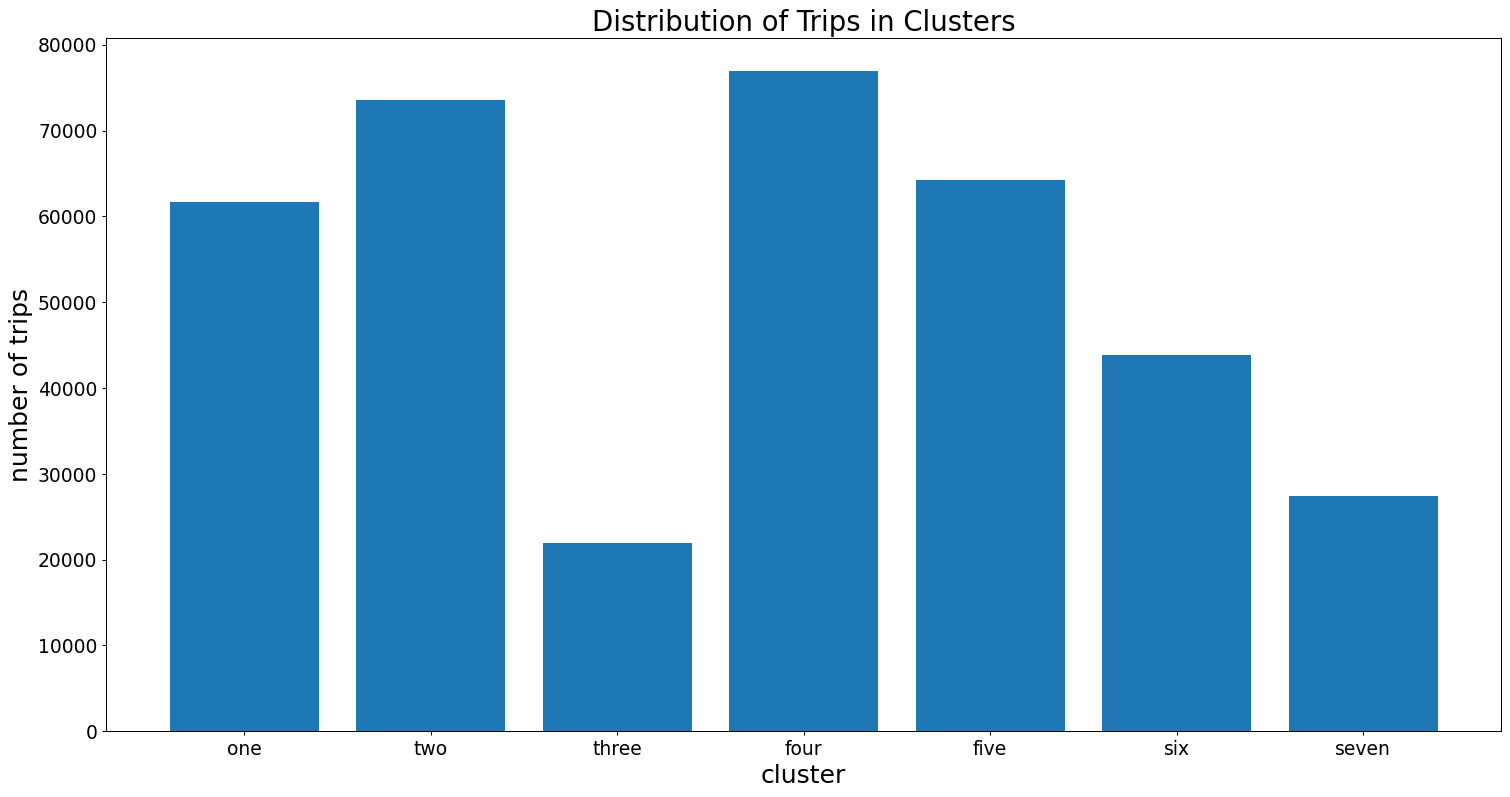

In [56]:
#customer data
count_c = [len(trip_types_scaled_c[trip_types_scaled_c.cluster==numbers_c[i]]) for i in range(len(numbers_c))]

fig,ax = plt.subplots(figsize=(20,10), dpi=90) 
axis_font = {'size':'20'}
label_font = {'labelsize':'15'}
dic={'fontsize': '22'}

ax.set_title("Distribution of Trips in Clusters", dic)
ax.set_ylabel("number of trips", **axis_font)
ax.set_xlabel("cluster", **axis_font)
ax.tick_params(axis='both', **label_font)
    
plt.bar(numbers_c,count_c)
plt.show()

In [ ]:
#full data
g = sns.pairplot(data=trip_types_scaled, hue="cluster_eight", hue_order=numbers, 
                 height=5, vars=["duration_in_hours","weekday","hour"])

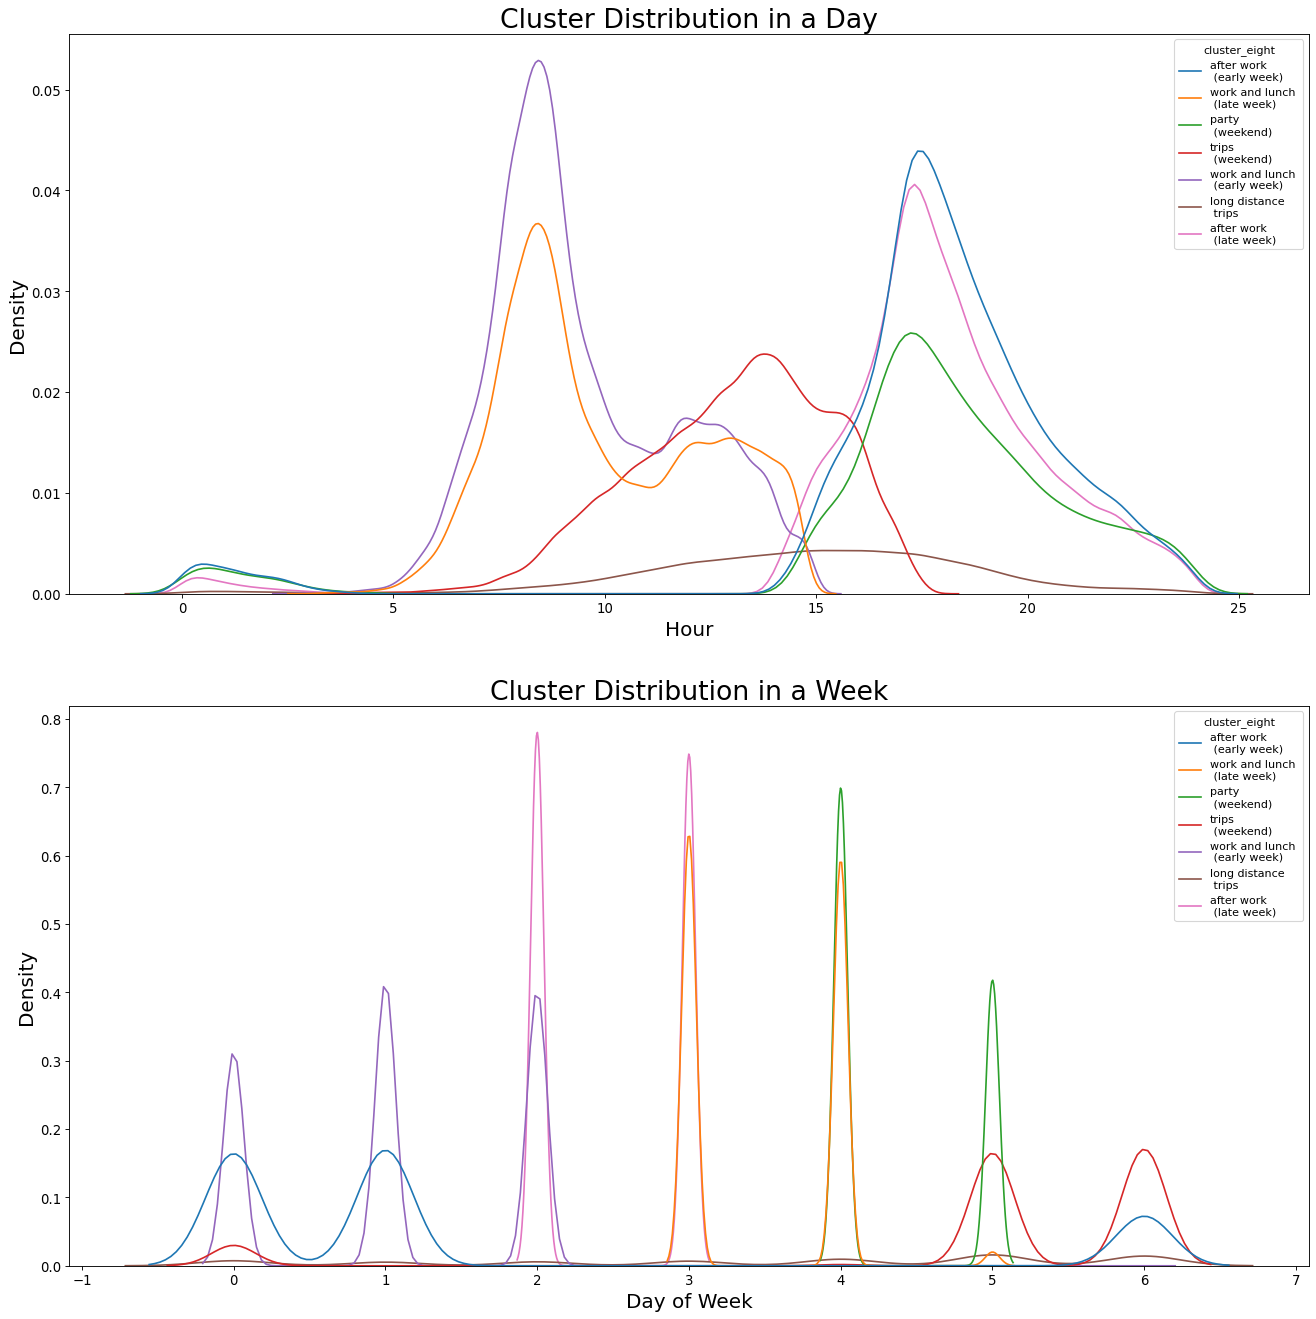

In [70]:
fig,ax = plt.subplots(2,1,figsize=(20,20), dpi= 80) 
axis_font = {'size':'18'}
label_font = {'labelsize':'12'}
dic={'fontsize': '24'}

sns.kdeplot(data=trip_types_scaled, x="hour", hue="cluster_eight",hue_order=numbers, ax=ax[0])
sns.kdeplot(data=trip_types_scaled, x="weekday", hue="cluster_eight",hue_order=numbers, ax=ax[1])


ax[0].set_title("Cluster Distribution in a Day", dic)
ax[0].set_ylabel("Density", **axis_font)
ax[0].set_xlabel("Hour", **axis_font)
ax[0].tick_params(axis='both', **label_font)

ax[1].set_title("Cluster Distribution in a Week", dic)
ax[1].set_ylabel("Density", **axis_font)
ax[1].set_xlabel("Day of Week", **axis_font)
ax[1].tick_params(axis='both', **label_font)

plt.show()

clusters:
- one (blue): sunday - tuesday, between 3 pm and 2 am, peaks at 6.30 pm 
-> after work (early week)
- two (orange): thursday - friday, between 5 am and 3 pm, peaks at 8 am (small peak at 12 pm) 
-> work and lunch break (late week)
- three (green): friday - saturday, between 3 pm and 2 am, peaks at 6 pm 
-> party (weekend)
- four (red): saturday - sunday, between 8 am and 6 pm, peaks from 1 pm to 2 pm 
-> trips (weekend)
- five (purple): monday - wednesday, between 5 am and 3 pm, peaks at 8 am (small peak at 12 pm) 
-> work and lunch break (early week)
- six (brown): distributed equally over week, between 10 am and 8 pm, long distance rides
-> long distance trips
- seven (pink): wednesday - thursday, between 3 pm and 2 am, peaks at 6 pm
-> after work (late week)


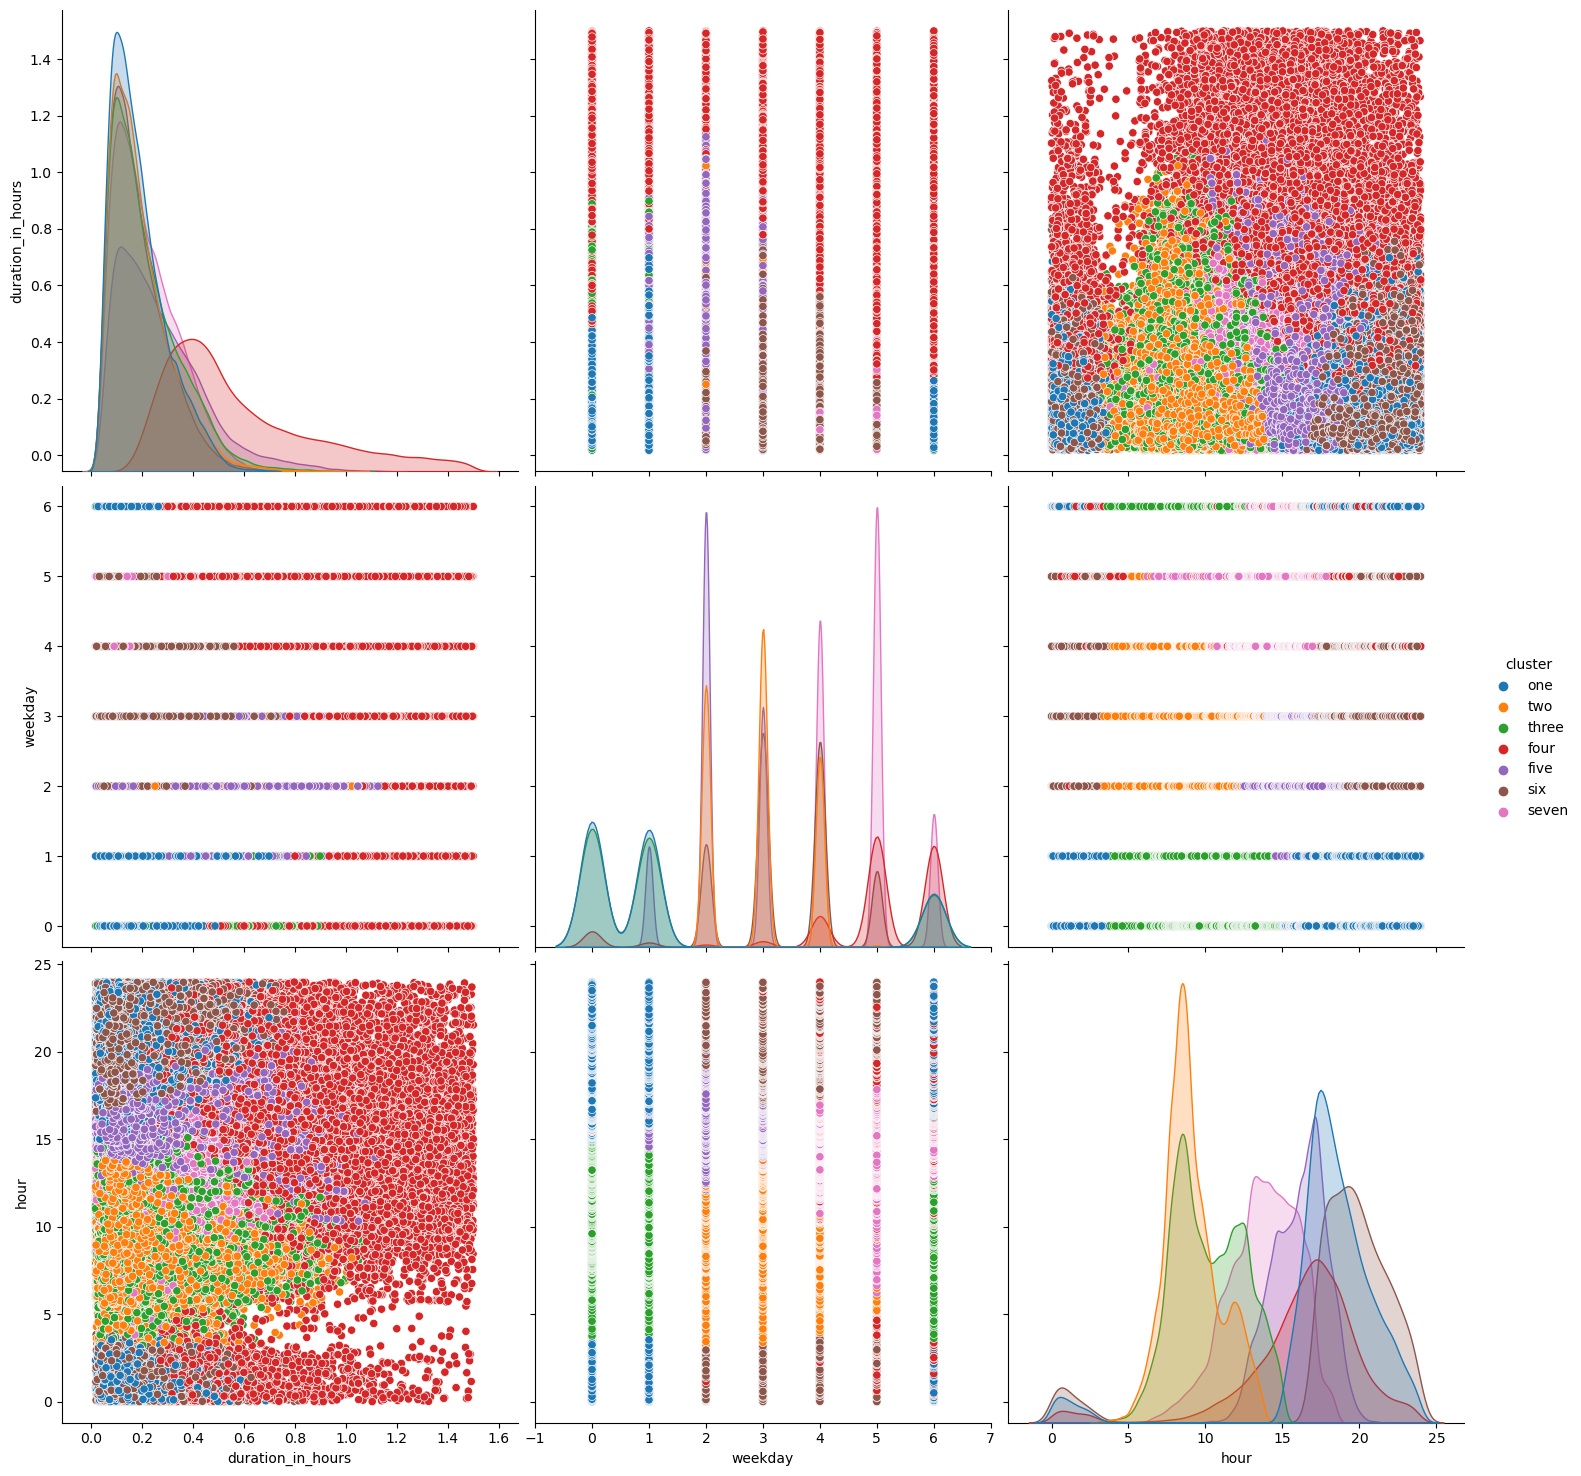

In [58]:
#subscriber data
g = sns.pairplot(data=trip_types_scaled_s, hue="cluster", hue_order=numbers_s, 
                 height=5, vars=["duration_in_hours","weekday","hour"])

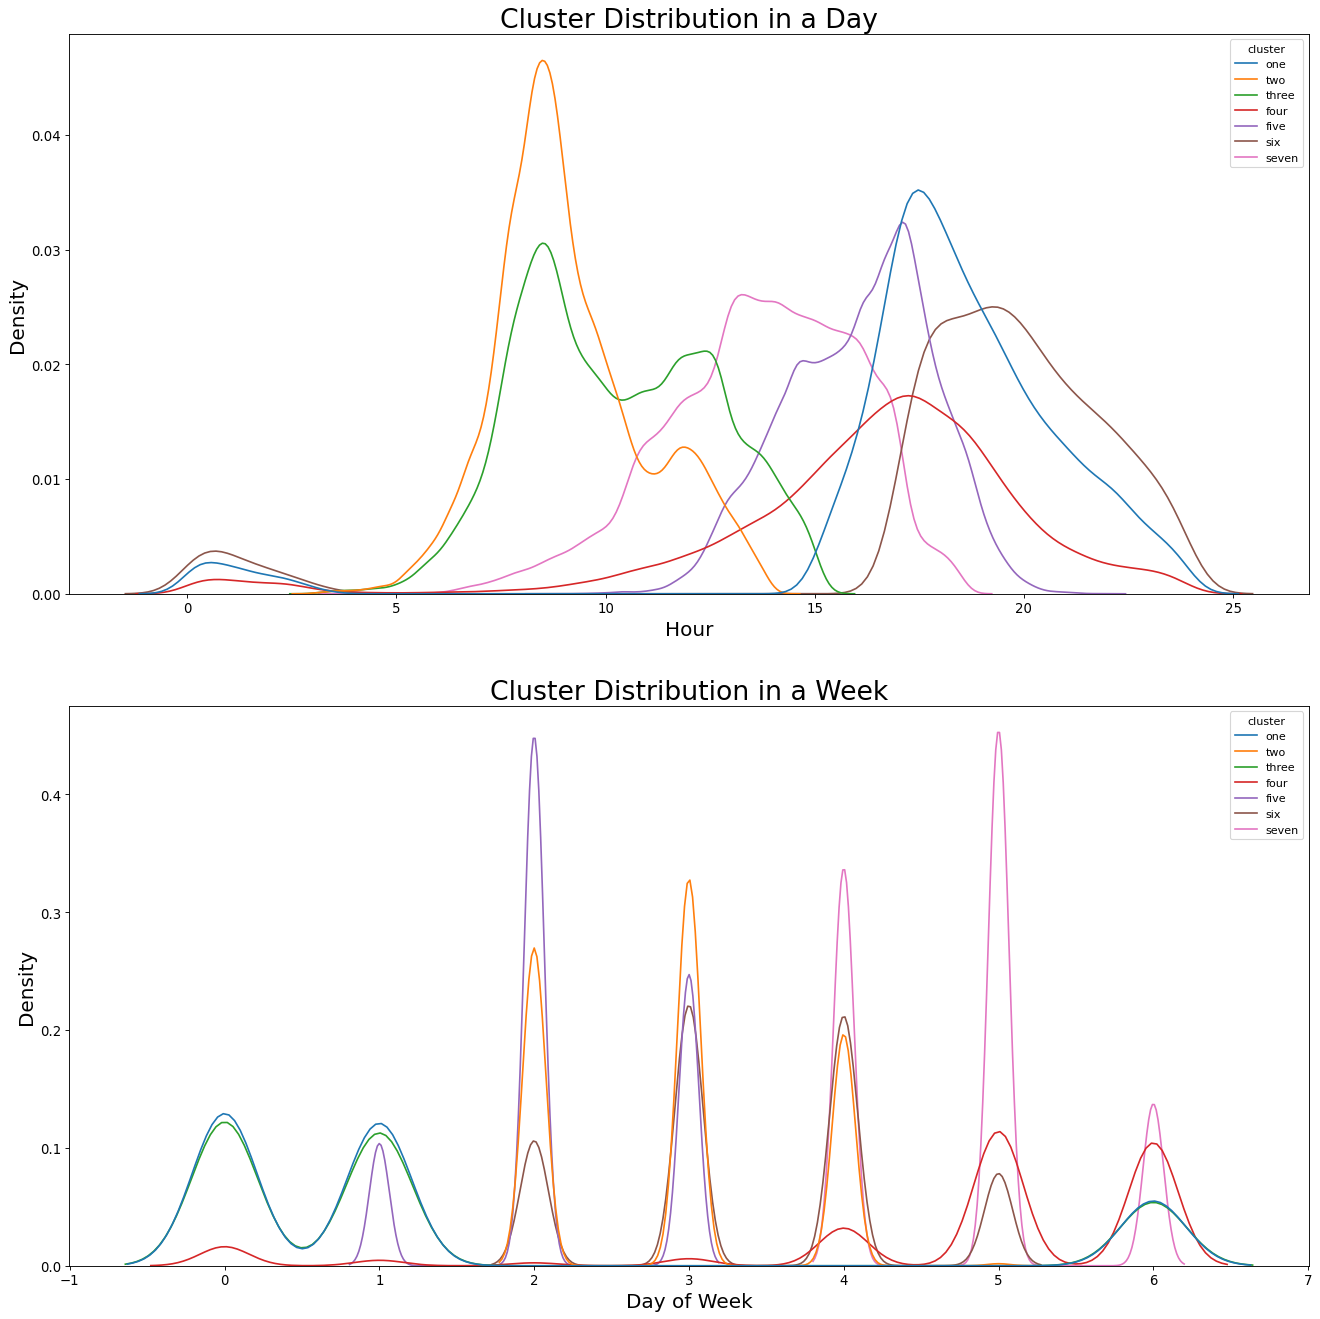

In [57]:
#subscriber data
fig,ax = plt.subplots(2,1,figsize=(20,20), dpi= 80) 
axis_font = {'size':'18'}
label_font = {'labelsize':'12'}
dic={'fontsize': '24'}

sns.kdeplot(data=trip_types_scaled_s, x="hour", hue="cluster",hue_order=numbers_s, ax=ax[0])
sns.kdeplot(data=trip_types_scaled_s, x="weekday", hue="cluster",hue_order=numbers_s, ax=ax[1])


ax[0].set_title("Cluster Distribution in a Day", dic)
ax[0].set_ylabel("Density", **axis_font)
ax[0].set_xlabel("Hour", **axis_font)
ax[0].tick_params(axis='both', **label_font)

ax[1].set_title("Cluster Distribution in a Week", dic)
ax[1].set_ylabel("Density", **axis_font)
ax[1].set_xlabel("Day of Week", **axis_font)
ax[1].tick_params(axis='both', **label_font)

plt.show()

- one: after work early week
- two: work and lunch mid week
- three: work and lunch early week
- four: long distance trips (throughout week but mostly on weekends) peaking in afternoon
- five: after work mid week
- six: going out in the evening during week
- seven: weekend trips during the day 

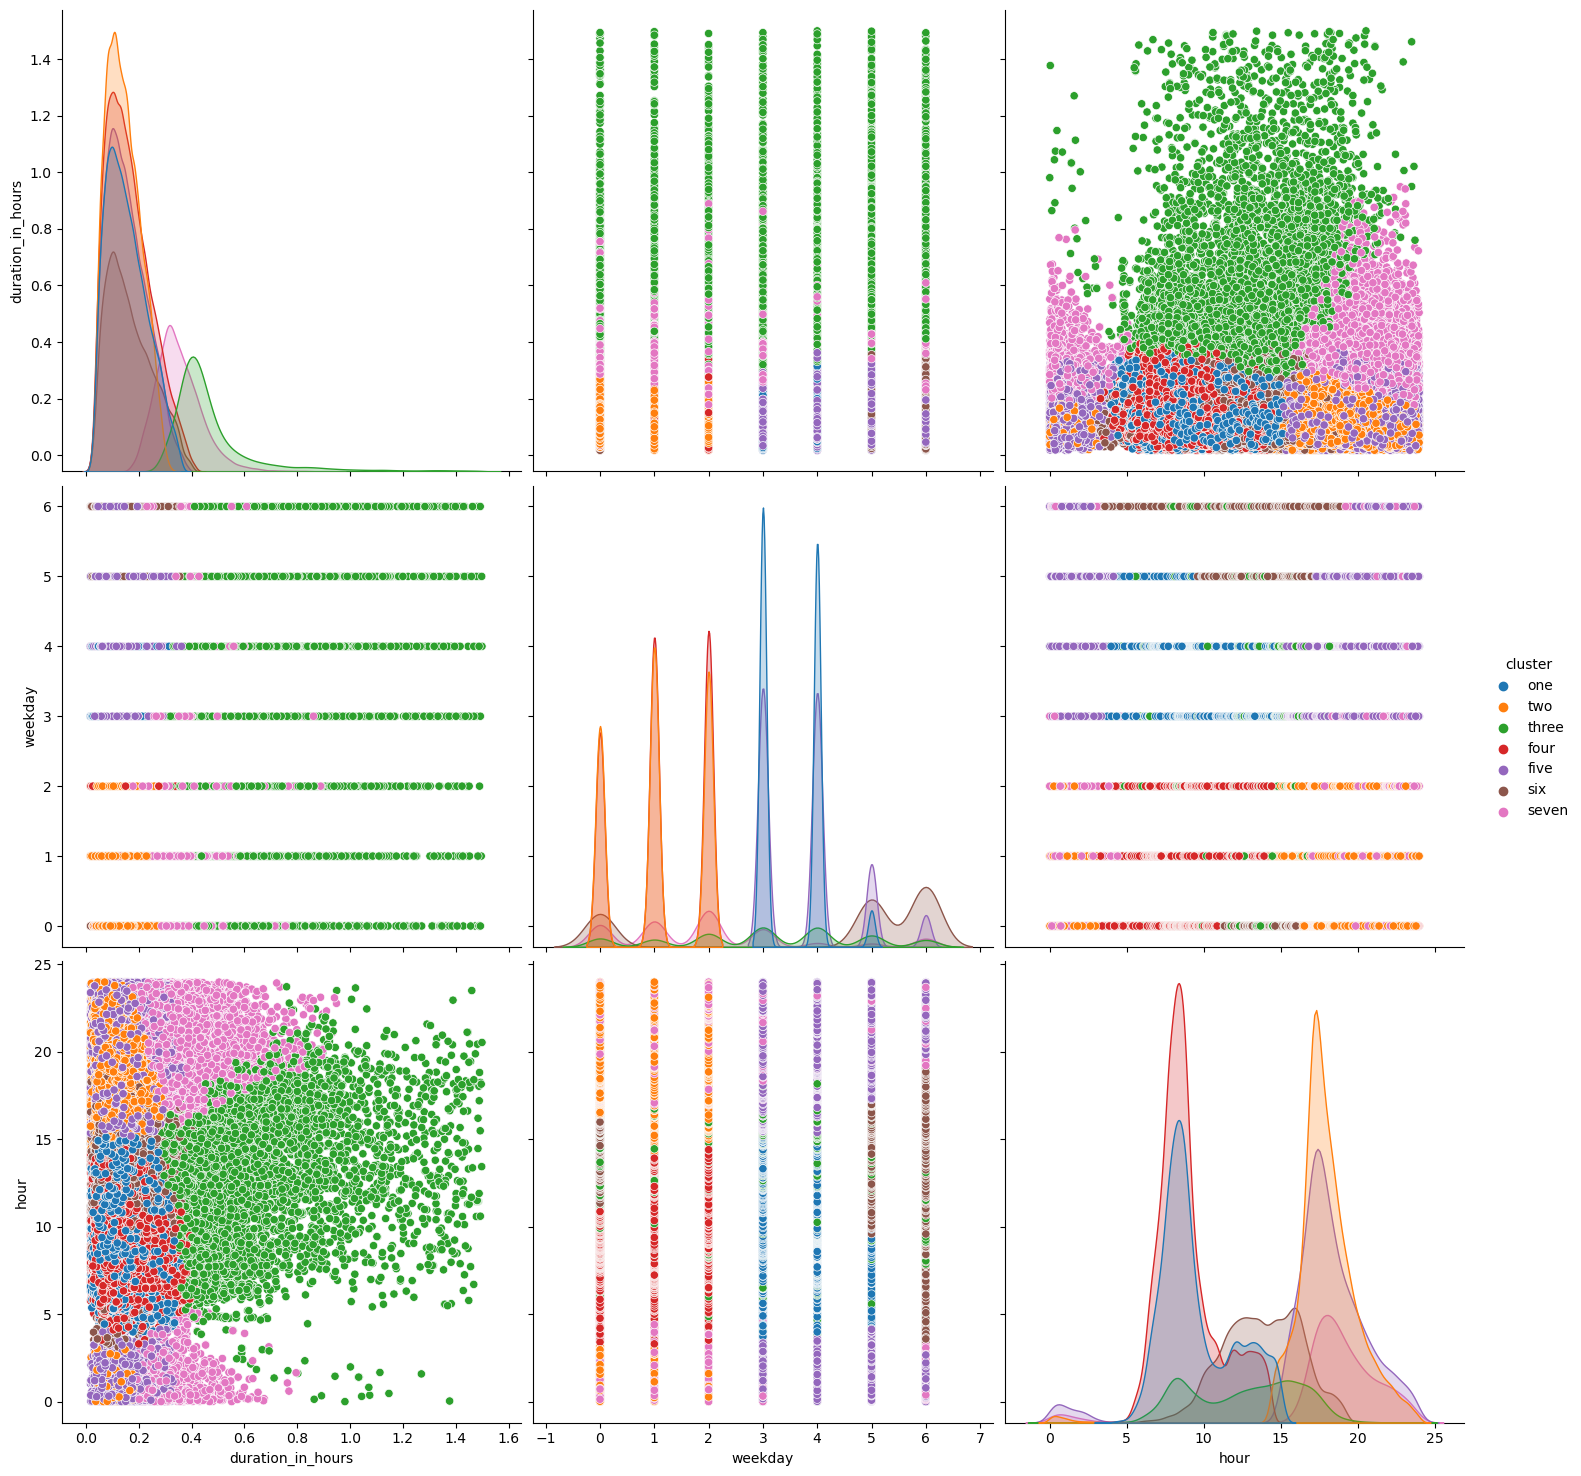

In [59]:
#customer data
g = sns.pairplot(data=trip_types_scaled_c, hue="cluster", hue_order=numbers_c, 
                 height=5, vars=["duration_in_hours","weekday","hour"])

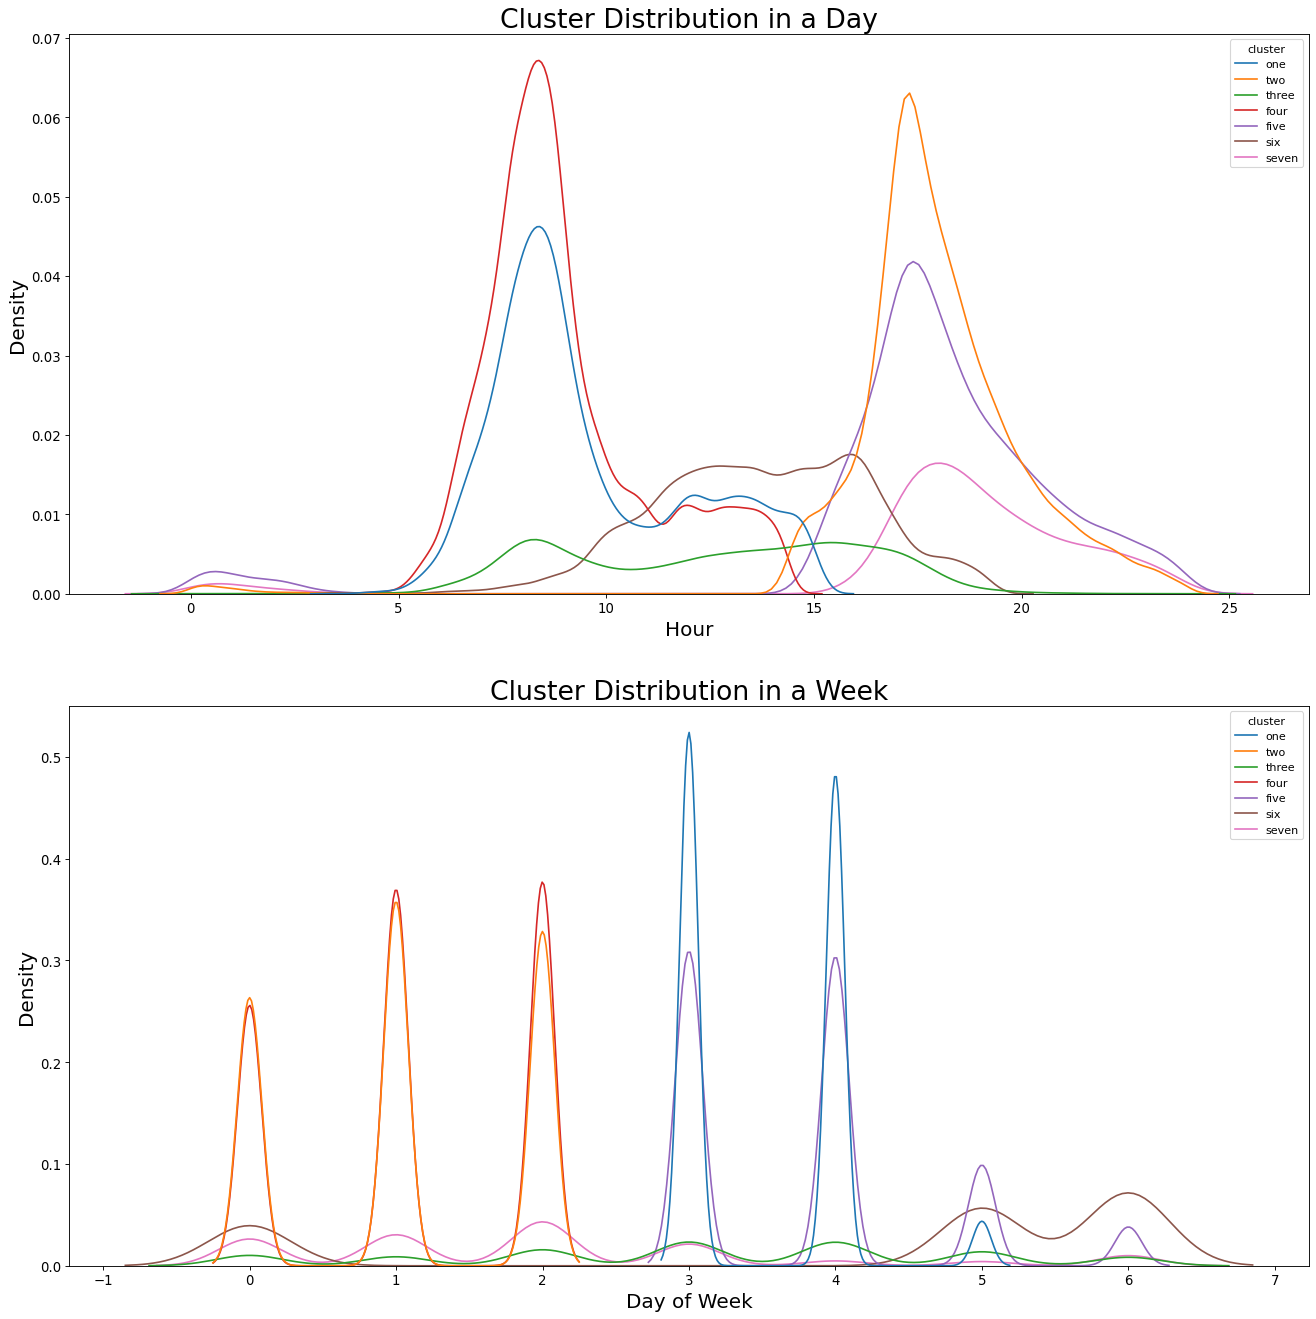

In [60]:
#subscriber data
fig,ax = plt.subplots(2,1,figsize=(20,20), dpi= 80) 
axis_font = {'size':'18'}
label_font = {'labelsize':'12'}
dic={'fontsize': '24'}

sns.kdeplot(data=trip_types_scaled_c, x="hour", hue="cluster",hue_order=numbers_c, ax=ax[0])
sns.kdeplot(data=trip_types_scaled_c, x="weekday", hue="cluster",hue_order=numbers_c, ax=ax[1])


ax[0].set_title("Cluster Distribution in a Day", dic)
ax[0].set_ylabel("Density", **axis_font)
ax[0].set_xlabel("Hour", **axis_font)
ax[0].tick_params(axis='both', **label_font)

ax[1].set_title("Cluster Distribution in a Week", dic)
ax[1].set_ylabel("Density", **axis_font)
ax[1].set_xlabel("Day of Week", **axis_font)
ax[1].tick_params(axis='both', **label_font)

plt.show()

- one: work and lunch late week
- two: after work early week
- three: long distance trips 
- four: work and lunch early week
- five: after work late week
- six: weekend trips during the day
- seven: after work long distance trips (?)